In [1]:
import argparse
import subprocess
import sys
import warnings
warnings.filterwarnings("ignore")

import json
import matplotlib.pyplot as plt
import numpy as np
import scipy
import SimpleITK as sitk

# https://github.com/pyushkevich/histoannot.git
# git clone the GitHub repository and add the path to the sys.path
# This makes sure you are using the latest version of the code
sys.path.append('/Users/cathalye/Packages/histoannot/')
import phas.client.api as phas
from phas.dltrain import spatial_transform_roi

(1000, 867)


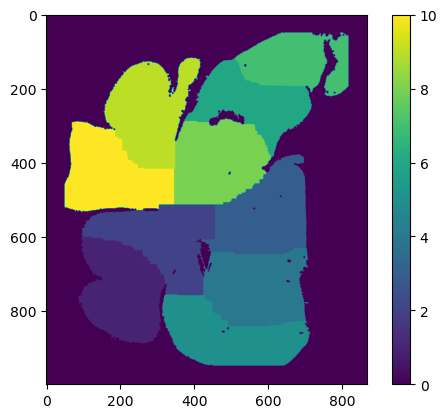

In [2]:
registration_dir = "./data/INDD102115/HR2a/registration"
chunk_mask_orig = sitk.ReadImage(f"{registration_dir}/reference_multi_chunk.nii.gz")
chunk_mask_arr = sitk.GetArrayFromImage(chunk_mask_orig)[0, :, :]
# Replace 50 pixels along all borders with value 0
chunk_mask_arr[:50, :] = 0
chunk_mask_arr[-50:, :] = 0
chunk_mask_arr[:, :50] = 0
chunk_mask_arr[:, -50:] = 0
chunk_mask = sitk.GetImageFromArray(chunk_mask_arr)

print(chunk_mask_arr.shape)
chunk_mask_arr = chunk_mask_arr
plt.imshow(chunk_mask_arr)
plt.colorbar()

In [3]:
chunk_ids = np.unique(chunk_mask_arr)
chunk_ids = chunk_ids[chunk_ids != 0]
print(chunk_ids)

def chunk_dist_map(k):
    # Extract only the chunk with label k
    mask = sitk.BinaryThreshold(chunk_mask, int(k), int(k), 1, 0)
    plt.imshow(sitk.GetArrayFromImage(mask))
    return sitk.SignedDanielssonDistanceMap(mask, insideIsPositive=False, squaredDistance=True)

[ 1  2  3  4  5  6  7  8  9 10]


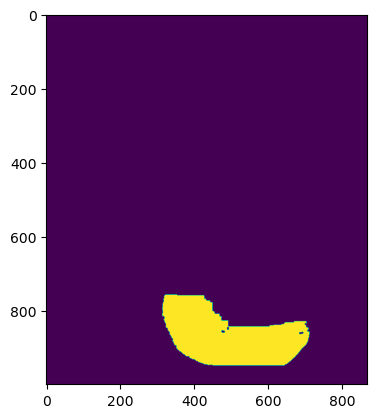

In [4]:
chunk_dist_map1 = chunk_dist_map(5)
chunk_dist_map1_arr = sitk.GetArrayFromImage(chunk_dist_map1)


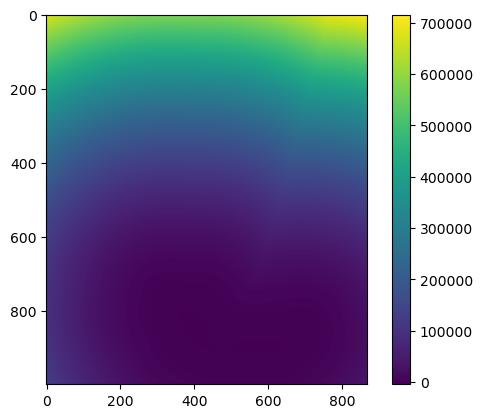

In [5]:
plt.imshow(chunk_dist_map1_arr)
plt.colorbar()

In [6]:
print(type(chunk_ids[1]))

<class 'numpy.int16'>


(10, 867000)


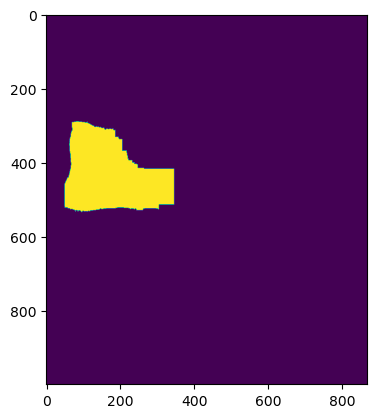

In [7]:
# Get a list of distance masks for all chunks
# Dictionary with key as chunk id and value as distance map
dist_cmask = { k: chunk_dist_map(k) for k in chunk_ids }
# Convert the distance maps to numpy arrays
dist = np.array([ dist_cmask[k] for k in chunk_ids ])
print(dist.shape)


(867000,)
5


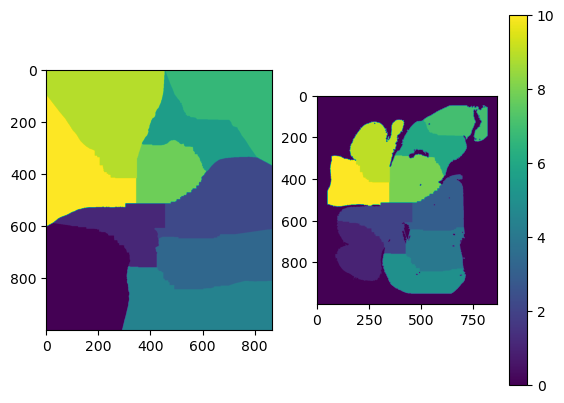

In [19]:
chunk = chunk_ids[np.argmin(dist, axis = 0)]
print(chunk.shape)
dist_map_all = np.reshape(chunk, chunk_mask_arr.shape)


plt.subplot(1, 2, 1)
plt.imshow(dist_map_all)
plt.subplot(1, 2, 2)
plt.imshow(chunk_mask_arr)
plt.colorbar()

print(dist_map_all[879, 337])

In [9]:
dist_map_all[200, 800]

7

(867, 1000)
(1000, 867)


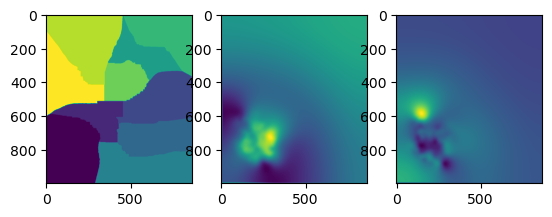

In [16]:
import scipy.interpolate


# for k in chunk_ids:
k = 1
chunk_str = f"{k:02d}"
chunk_rigid = np.loadtxt(f"{registration_dir}/output_piecewise_rigid_{chunk_str}.mat")
chunk_deformable = sitk.ReadImage(f"{registration_dir}/output_piecewise_deformable_{chunk_str}.nii.gz")


print(chunk_deformable.GetSize())
print(chunk_mask_arr.shape)

interp = scipy.interpolate.RegularGridInterpolator([np.arange(chunk_mask_arr.shape[k]) for k in (0,1)],
                                                         sitk.GetArrayFromImage(chunk_deformable))

# print(interp)
# deform = interp(dist_map_all)
plt.subplot(1,3,1)
plt.imshow(dist_map_all)
plt.subplot(1,3,2)
plt.imshow(interp.values[:,:,0])
plt.subplot(1,3,3)
plt.imshow(interp.values[:,:,1])